The goal of this notebook is to understand if the mutation-probability-weighted landscape of affinity changes due to mutation varies through time. We evaluate this using the 10x data.

In [1]:
import os
import tempfile
cache_dir = tempfile.mkdtemp()
os.environ['XDG_CACHE_HOME'] = cache_dir
import re

from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.Seq import Seq
from Bio.Data import CodonTable


In [2]:
fivemer_mut_path = "../data/mutability/MK_RS5NF_mutability.csv"
fivemer_sub_path = "../data/mutability/MK_RS5NF_substitution.csv"
seq_data_path = "../results/notebooks/10x/data.csv"
final_variant_scores = "data/dms/final_variant_scores.csv"

In [3]:
fivemer_mut_df = pd.read_csv(fivemer_mut_path, sep=" ", header=0)
fivemer_sub_df = pd.read_csv(fivemer_sub_path, sep=" ", header=0)


#### Read in the sequences and trim to codon boundary

In [4]:
seq_data_df = pd.read_csv(seq_data_path, usecols=["nt_seq_H", "nt_seq_L", "time (days)"])

# Check for missing values in the sequence columns
assert seq_data_df["nt_seq_H"].isnull().sum() == 0
assert seq_data_df["nt_seq_L"].isnull().sum() == 0

# Trim sequences to codon boundary
seq_data_df["nt_seq_H"] = seq_data_df["nt_seq_H"].apply(lambda x: str(x)[:len(str(x)) // 3 * 3])
seq_data_df["nt_seq_L"] = seq_data_df["nt_seq_L"].apply(lambda x: str(x)[:len(str(x)) // 3 * 3])

# print the length of all the seq columns
print("Length of nt_seq_H:", seq_data_df["nt_seq_H"].str.len().unique())
print("Length of nt_seq_L:", seq_data_df["nt_seq_L"].str.len().unique())

Length of nt_seq_H: [336]
Length of nt_seq_L: [321]


In [5]:
# get the first sequence
seq_data_df["nt_seq_H"].iloc[0], seq_data_df["nt_seq_L"].iloc[0]

('GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATCAGCTACAGTGGTAGCACTTACTCCAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCA',
 'GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGCCAGAATGTGGGTACTAATGTAGGCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAA')

#### Read in the variant scores

In [6]:
final_variant_scores_df = pd.read_csv(final_variant_scores)

# renumber positions for the light chain starting at 1
mask = final_variant_scores_df["chain"] == "L"
final_variant_scores_df.loc[mask, "position"] -= final_variant_scores_df.loc[mask, "position"].min() - 1

final_variant_scores_df = final_variant_scores_df[final_variant_scores_df["chain"] != "link"]
# get the unique "codon" entry for final_variant_scores_df.groupby(["chain", "site"])
unique_codons = final_variant_scores_df.groupby(["chain", "position"])["codon"].unique()
# let unique_codons be the first entry of unique_codons
unique_codons = unique_codons.apply(lambda x: x[0])
# concatenate unique_codons for chain="H" to be one string, naive_H, and for chain="L" to be one string, naive_L
naive_H = "".join(unique_codons.loc["H"])
naive_L = "".join(unique_codons.loc["L"])

len(naive_H), len(naive_L)

(336, 324)

#### Now let's look at the sequence differences

Note above that the naive sequence length is 1 codon longer than the codon-boundary-trimmed 10x data, so we will need to trim the data explicitly.

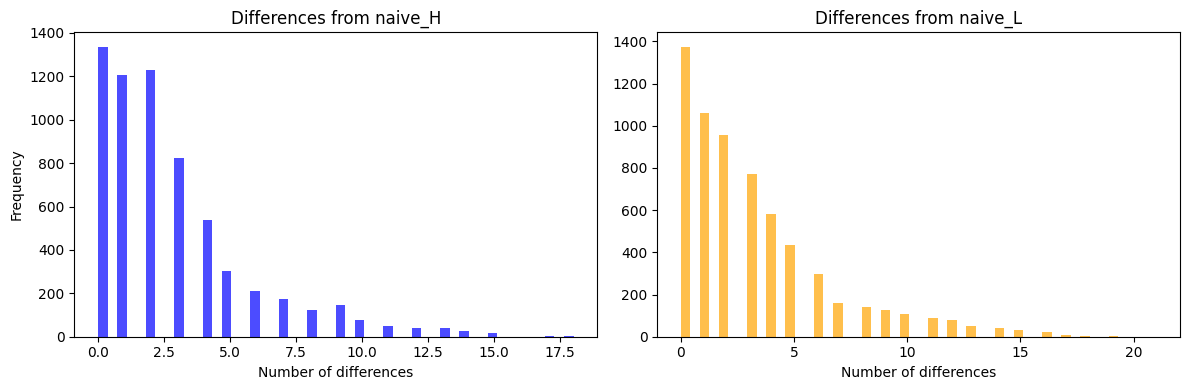

In [7]:
# for nt_seq_H entry, calculate the number of differences from naive_H
def diff(seq1, seq2):
    assert len(seq1) == len(seq2), f"Sequences must be of the same length: {len(seq1)} != {len(seq2)}"
    return sum([1 for a, b in zip(seq1, seq2) if a != b])

seq_data_df["diff_H"] = seq_data_df["nt_seq_H"].apply(lambda x: diff(x, naive_H))
seq_data_df["diff_L"] = seq_data_df["nt_seq_L"].apply(lambda x: diff(x, naive_L[:321]))

# make histograms of diff_H and diff_L
plt.figure(figsize=(12, 4))

# Plot both histograms side by side
plt.subplot(121)
plt.hist(seq_data_df["diff_H"], bins=50, color="blue", alpha=0.7)
plt.title("Differences from naive_H")
plt.xlabel("Number of differences")
plt.ylabel("Frequency")

plt.subplot(122)
plt.hist(seq_data_df["diff_L"], bins=50, color="orange", alpha=0.7)
plt.title("Differences from naive_L")
plt.xlabel("Number of differences")

plt.tight_layout()
plt.show()

# drop the diff_H and diff_L columns
seq_data_df = seq_data_df.drop(columns=["diff_H", "diff_L"])


In [8]:
downsampling_count = 100

print("Before downsampling:")
print(seq_data_df["time (days)"].value_counts())

np.random.seed(42)

# Create a new empty DataFrame to hold results
result_df = pd.DataFrame()

# Process each time value
for time_val, group in seq_data_df.groupby("time (days)"):
    n_samples = min(downsampling_count, len(group))
    sampled = group.sample(n=n_samples, replace=False, random_state=42)
    result_df = pd.concat([result_df, sampled])

# Reset index of final result
result_df = result_df.reset_index(drop=True)

# Verify the results
print("\n After downsampling:")
seq_data_df = result_df.copy()
print(seq_data_df["time (days)"].value_counts())

Before downsampling:
time (days)
8     1499
11    1225
17    1011
14    1005
20     780
70     701
5      120
Name: count, dtype: int64

 After downsampling:
time (days)
5     100
8     100
11    100
14    100
17    100
20    100
70    100
Name: count, dtype: int64


In [9]:
# Create the mutability dictionary directly from the dataframe
mutability_dict = dict(zip(fivemer_mut_df['Fivemer'], fivemer_mut_df['Mutability']))

def get_sequence_mutability(sequence: str) -> np.ndarray:
    """
    Compute raw mutability scores for each position in a DNA sequence.
    
    Args:
        sequence: A DNA sequence (e.g., "GAGGTGCAGCTT...")
        
    Returns:
        numpy array with raw mutability scores
    """
    sequence = sequence.upper()
    padded_seq = "NN" + sequence + "NN"
    mutability_scores = np.zeros(len(sequence))
    
    for i in range(len(sequence)):
        fivemer = padded_seq[i:i+5]
        mutability_scores[i] = mutability_dict[fivemer]
    
    return mutability_scores


def compute_normalized_mutability_pair(heavy_chain: str, light_chain: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute mutability scores for heavy and light chain sequences, then normalize
    them as if they were a single probability vector.
    
    Args:
        heavy_chain: DNA sequence for heavy chain
        light_chain: DNA sequence for light chain
        
    Returns:
        Tuple of two numpy arrays with normalized mutability scores
    """
    heavy_mutability = get_sequence_mutability(heavy_chain)
    light_mutability = get_sequence_mutability(light_chain)
    
    total_mutability = np.sum(heavy_mutability) + np.sum(light_mutability)
    
    # Normalize both sequences using the same total
    heavy_normalized = heavy_mutability / total_mutability
    light_normalized = light_mutability / total_mutability
    
    return heavy_normalized, light_normalized

In [10]:
# Apply the function to each pair of sequences in the dataframe
normalized_mutability_results = []

for _, row in seq_data_df.iterrows():
    heavy_chain = row['nt_seq_H']
    light_chain = row['nt_seq_L']
    
    heavy_norm, light_norm = compute_normalized_mutability_pair(heavy_chain, light_chain)
    normalized_mutability_results.append((heavy_norm, light_norm))

# Unpack the results and add them to the dataframe
seq_data_df['norm_mutability_H'] = [result[0] for result in normalized_mutability_results]
seq_data_df['norm_mutability_L'] = [result[1] for result in normalized_mutability_results]

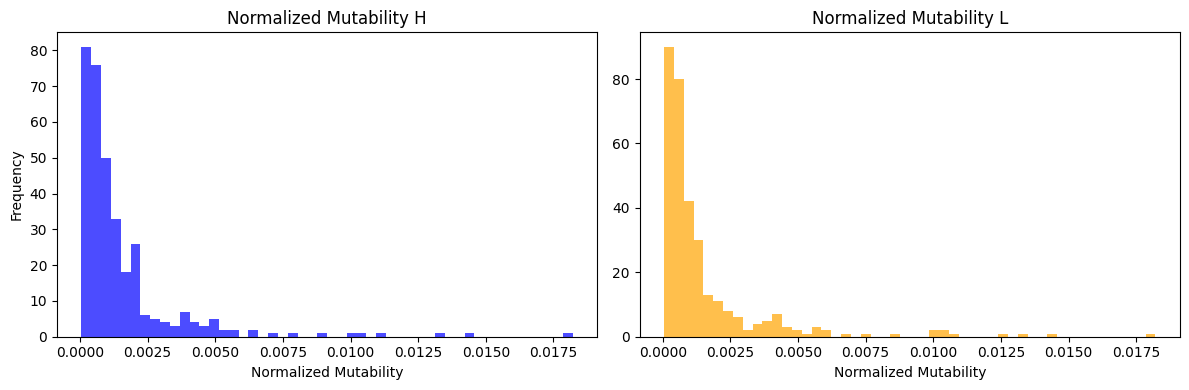

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(seq_data_df['norm_mutability_H'].iloc[0], bins=50, color="blue", alpha=0.7)
plt.title("Normalized Mutability H")
plt.xlabel("Normalized Mutability")
plt.ylabel("Frequency")
plt.subplot(122)
plt.hist(seq_data_df['norm_mutability_L'].iloc[0], bins=50, color="orange", alpha=0.7)
plt.title("Normalized Mutability L")
plt.xlabel("Normalized Mutability")
plt.tight_layout()

assert np.isclose(seq_data_df['norm_mutability_H'].iloc[0].sum() + seq_data_df['norm_mutability_L'].iloc[0].sum(), 1.0), "Normalized mutability scores do not sum to 1"


In [12]:
def calculate_aa_mutation_probabilities(seq_data_df, fivemer_sub_df):
    # Precompute codon table using Biopython
    standard_table = CodonTable.standard_dna_table
    codon_table = {}
    for codon, aa in standard_table.forward_table.items():
        codon_table[codon] = aa
    # Add stop codons
    for codon in standard_table.stop_codons:
        codon_table[codon] = '*'
    
    # Precompute fivemer substitution lookup
    fivemer_lookup = {}
    for _, row in fivemer_sub_df.iterrows():
        fivemer = row['Fivemer']
        fivemer_lookup[fivemer] = {
            'A': row['A'],
            'C': row['C'],
            'G': row['G'],
            'T': row['T']
        }
    
    aa_mutation_probs = {}
    
    # Process each sequence
    for idx, row in seq_data_df.iterrows():
        # Pad sequences for 5mer context only
        padded_seq_H = "NN" + row['nt_seq_H'] + "NN"
        padded_seq_L = "NN" + row['nt_seq_L'] + "NN"
        
        # Original mutability vectors (no padding needed)
        mut_H = row['norm_mutability_H']
        mut_L = row['norm_mutability_L']
        
        # Process heavy chain
        process_chain(padded_seq_H, mut_H, 'H', fivemer_lookup, codon_table, aa_mutation_probs)
        
        # Process light chain
        process_chain(padded_seq_L, mut_L, 'L', fivemer_lookup, codon_table, aa_mutation_probs)
    
    # Convert to dataframe
    aa_mut_prob_df = pd.DataFrame({
        'aa_mut': list(aa_mutation_probs.keys()),
        'prob_tot': list(aa_mutation_probs.values())
    })
    
    return aa_mut_prob_df

def process_chain(padded_seq, mutability, chain, fivemer_lookup, codon_table, aa_mutation_probs):
    # Original sequence without padding
    orig_seq = padded_seq[2:-2]
    
    # Process each position in the original sequence
    for pos in range(len(orig_seq)):
        # Get the original nucleotide
        orig_nt = orig_seq[pos]
        
        # Get the padded position (for fivemer context)
        padded_pos = pos + 2
        
        # Get the fivemer centered at this position
        fivemer = padded_seq[padded_pos-2:padded_pos+3]
        
        # Get the codon that this nucleotide is part of
        codon_pos = pos - (pos % 3)
        orig_codon = orig_seq[codon_pos:codon_pos + 3]
        
        # Get the original amino acid
        orig_aa = codon_table[orig_codon]
        
        # Calculate 1-indexed amino acid position
        aa_pos = (codon_pos // 3) + 1
        
        # Get the mutability at this position
        mut_prob = mutability[pos]
        
        # For each possible substitution
        for new_nt in 'ACGT':
            # Skip self-substitutions on the nucleotide level
            if new_nt == orig_nt:
                continue
            
            # Calculate the probability of this substitution
            sub_prob = fivemer_lookup[fivemer][new_nt]
            nt_mut_prob = mut_prob * sub_prob
            
            # Create the new codon
            codon_idx_in_triplet = pos % 3
            new_codon = list(orig_codon)
            new_codon[codon_idx_in_triplet] = new_nt
            new_codon = ''.join(new_codon)
            
            # Get the new amino acid
            new_aa = codon_table[new_codon]
            
            # Record all mutations, including self-mutations at AA level
            aa_mut = f"{orig_aa}{aa_pos}({chain}){new_aa}"
            
            # Update the probability for this amino acid mutation
            if aa_mut in aa_mutation_probs:
                aa_mutation_probs[aa_mut] += nt_mut_prob
            else:
                aa_mutation_probs[aa_mut] = nt_mut_prob

In [13]:
# Group the sequences by time and create a dictionary of results
mut_probs_by_time = {}
for time_value, group_df in seq_data_df.groupby('time (days)'):
    mut_probs_by_time[time_value] = calculate_aa_mutation_probabilities(group_df, fivemer_sub_df)

In [14]:
def collapse_by_prefix(df):
    # Create a copy of the dataframe to avoid modifying the original
    temp_df = df.copy()
    
    # Extract prefix (all characters except the last) from aa_mut column
    temp_df['prefix'] = temp_df['aa_mut'].str[:-1]
    
    # Group by prefix and sum the probabilities
    result_df = temp_df.groupby('prefix')['prob_tot'].sum().reset_index()
    
    # Rename columns for clarity
    result_df = result_df.rename(columns={'prefix': 'aa_mut'})
    
    # Extract the numeric part for sorting
    # This assumes format like E1(H) where 1 is the number to sort by
    result_df['sort_key'] = result_df['aa_mut'].str.extract(r'[A-Z](\d+)')
    result_df['sort_key'] = result_df['sort_key'].astype(int)
    
    # Sort by the numeric value and drop the helper column
    result_df = result_df.sort_values('sort_key').drop(columns=['sort_key'])
    
    return result_df

As a check, we can see that there are no non-naive original amino acids at time 5:

In [15]:
collapse_by_prefix(mut_probs_by_time[5])

,aa_mut,prob_tot
28,E1(H),0.280377
15,D1(L),0.183370
70,I2(L),0.194248
213,V2(H),0.769838
127,Q3(H),1.271897
...,...,...
183,T109(H),0.497187
1,A109(H),0.004566
209,V110(H),0.216343
148,S111(H),0.225715


But there are at time 70:

In [16]:
collapse_by_prefix(mut_probs_by_time[70])

,aa_mut,prob_tot
36,D1(L),0.197975
55,E1(H),0.295554
432,V1(H),0.016024
441,V2(H),0.827921
156,I2(L),0.212699
...,...,...
154,I110(H),0.006572
336,S111(H),0.239302
3,A111(H),0.003447
337,S112(H),0.153791


In [17]:
def parse_mutation_string(mutation_str):
    """Parse mutation string like 'E1(H)K' into components."""
    from_aa = mutation_str[0]
    to_aa = mutation_str[-1]
    
    # Extract position and chain
    parts = mutation_str[1:-1].split('(')
    position = int(parts[0])
    chain = parts[1][:-1]  # Remove closing parenthesis
    
    return from_aa, position, chain, to_aa

def compute_mutation_deltas(mut_probs_df, final_variant_scores_df):
    """Add delta_bind_CGG column to mut_probs_df with binding score changes."""
    # Build lookup dictionary for binding scores
    binding_scores = {}
    for _, row in final_variant_scores_df.iterrows():
        position = row['position']
        chain = row['chain']
        amino_acid = row['mutant']
        key = (position, chain, amino_acid)
        binding_scores[key] = row['delta_bind_CGG']
    
    # Calculate deltas for each mutation and add to dataframe
    delta_values = []
    for _, row in mut_probs_df.iterrows():
        mutation = row['aa_mut']
        from_aa, position, chain, to_aa = parse_mutation_string(mutation)
        
        # Handle stop codons
        if to_aa == '*':
            delta_values.append(np.nan)
            continue
        
        from_key = (position, chain, from_aa)
        to_key = (position, chain, to_aa)
        
        assert from_key in binding_scores, f"Could not find binding score for {from_key}"
        assert to_key in binding_scores, f"Could not find binding score for {to_key}"
        
        from_score = binding_scores[from_key]
        to_score = binding_scores[to_key]
        
        delta_values.append(to_score - from_score)
    
    # Add the delta values as a new column
    mut_probs_df['delta_bind_CGG'] = delta_values
    
    # Verify against expected deltas
    for _, row in final_variant_scores_df.iterrows():
        if row['wildtype'] == row['mutant']:
            continue  # Skip wild-type entries
        
        mutation_str = f"{row['wildtype']}{row['position']}({row['chain']}){row['mutant']}"
        mutation_indices = mut_probs_df.index[mut_probs_df['aa_mut'] == mutation_str].tolist()
        
        if len(mutation_indices) > 0:
            calculated_delta = mut_probs_df.loc[mutation_indices[0], 'delta_bind_CGG']
            expected_delta = row['delta_bind_CGG']
            
            # Skip NaN values
            if np.isnan(calculated_delta) or np.isnan(expected_delta):
                continue
                
            if not np.isclose(calculated_delta, expected_delta, atol=1e-4):
                print(f"Calculated delta {calculated_delta} doesn't match expected {expected_delta} for {mutation_str}")
    
    return mut_probs_df

In [18]:
for mut_probs in mut_probs_by_time.values():
    compute_mutation_deltas(mut_probs, final_variant_scores_df)

In [19]:
def plot_weighted_histogram(ax, df, bins=40, color='steelblue', alpha=0.7):
    """
    Plot a probability-weighted histogram of delta_bind_CGG values.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    df : pandas.DataFrame
        DataFrame containing 'prob_tot' and 'delta_bind_CGG' columns.
    bins : int or sequence
        Number of bins or bin edges for histogram.
    color : str
        Color for the histogram bars.
    alpha : float
        Transparency of histogram bars.
    """
    # Filter out rows with NaN in delta_bind_CGG
    valid_data = df.dropna(subset=['delta_bind_CGG'])
    
    if len(valid_data) == 0:
        ax.text(0.5, 0.5, "No valid data", ha='center', va='center')
        return
    
    # Get weights and values
    weights = valid_data['prob_tot'].values
    values = valid_data['delta_bind_CGG'].values
    
    # Normalize weights to sum to 1
    weights = weights / weights.sum()
    
    # Create bin edges ensuring we have bins at -1 and 1 for the clipped values
    bin_edges = np.linspace(-1, 1, bins)
    
    # Count outliers to annotate them
    below_min = np.sum(weights[values < -1])
    above_max = np.sum(weights[values > 1])
    
    # Create capped values, binning outliers at the boundaries
    capped_values = np.clip(values, -1, 1)
    
    # Plot histogram
    hist = ax.hist(
        capped_values,
        weights=weights,
        bins=bin_edges,
        color=color,
        alpha=alpha,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Annotate outliers if they exist
    if below_min > 0:
        ax.text(-0.98, hist[0][0] * 1.1, f"{below_min:.3f}", 
                va='bottom', ha='left', fontsize=8)
    
    if above_max > 0:
        ax.text(0.98, hist[0][-1] * 1.1, f"{above_max:.3f}", 
                va='bottom', ha='right', fontsize=8)
    
    # Despine
    sns.despine(ax=ax)
    
    # Add labels
    ax.set_xlabel('Δ Binding (CGG)')
    ax.set_ylabel('Probability Density')
    
    # Set x-axis limits
    ax.set_xlim(-1.05, 1.05)
    
    # Show the actual data stats to help debug
    ax.text(
        0.02, 0.98, 
        f"Mean: {np.average(values, weights=weights):.3f}\nStd: {np.sqrt(np.average((values-np.average(values, weights=weights))**2, weights=weights)):.3f}", 
        transform=ax.transAxes,
        va='top', ha='left', 
        fontsize=8,
        bbox=dict(facecolor='white', alpha=0.7)
    )

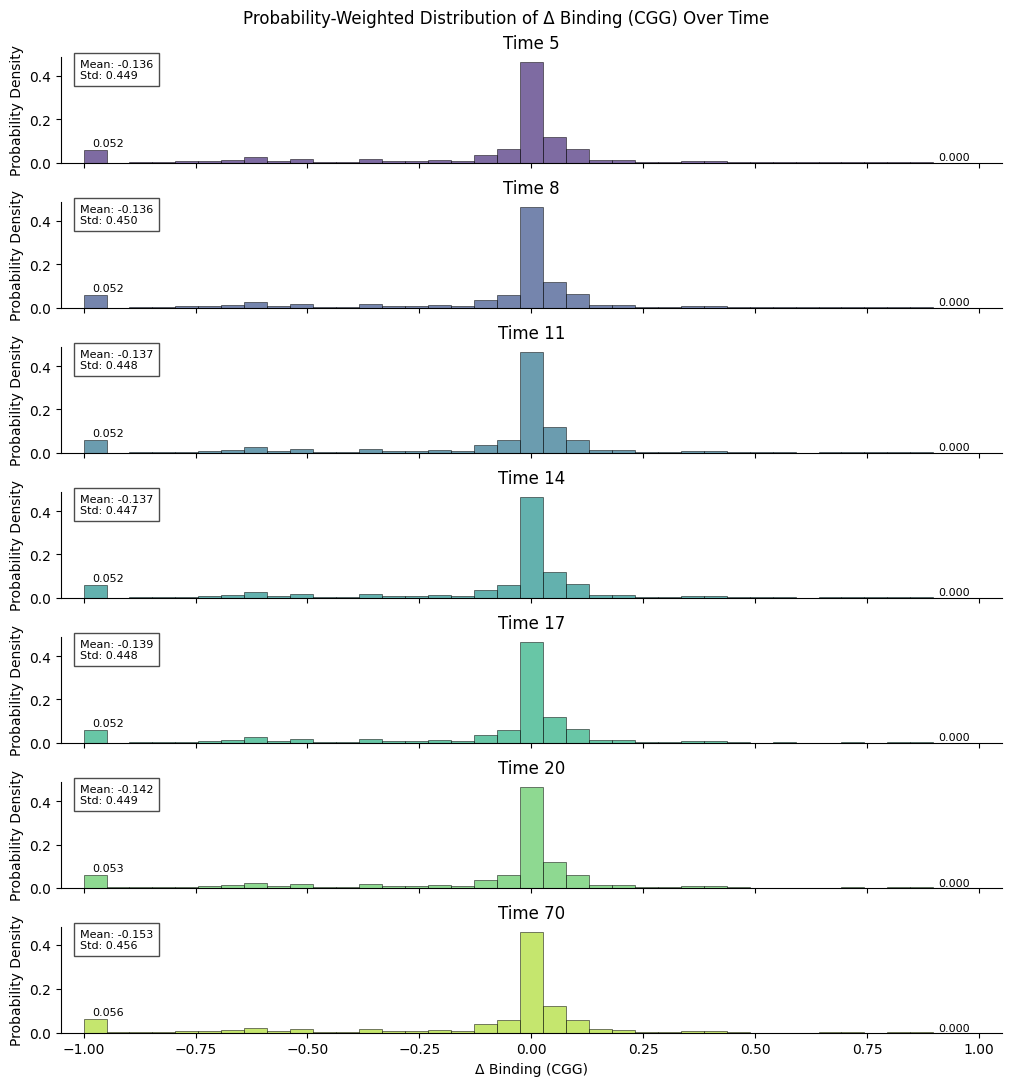

In [20]:
# Create a figure with subplots for each timepoint
fig, axes = plt.subplots(
    len(mut_probs_by_time), 
    1, 
    figsize=(10, 1.5 * len(mut_probs_by_time)),
    sharex=True,
    constrained_layout=True
)

# If there's only one timepoint, axes won't be an array
if len(mut_probs_by_time) == 1:
    axes = np.array([axes])

# Colors for the histograms
colors = sns.color_palette("viridis", len(mut_probs_by_time))

# Plot each timepoint
for i, (timepoint, df) in enumerate(sorted(mut_probs_by_time.items())):
    # Make a copy to avoid modifying the original data
    plot_df = df.copy()
    
    # Ensure we're working with different data for each timepoint
    plot_weighted_histogram(
        axes[i], 
        plot_df, 
        bins=40, 
        color=colors[i]
    )
    axes[i].set_title(f"Time {timepoint}")
    
    # For all but the last plot, remove x-axis labels
    if i < len(mut_probs_by_time) - 1:
        axes[i].set_xlabel("")

# Add an overall title
fig.suptitle("Probability-Weighted Distribution of Δ Binding (CGG) Over Time", y=1.02)

# Show the plot
plt.show()

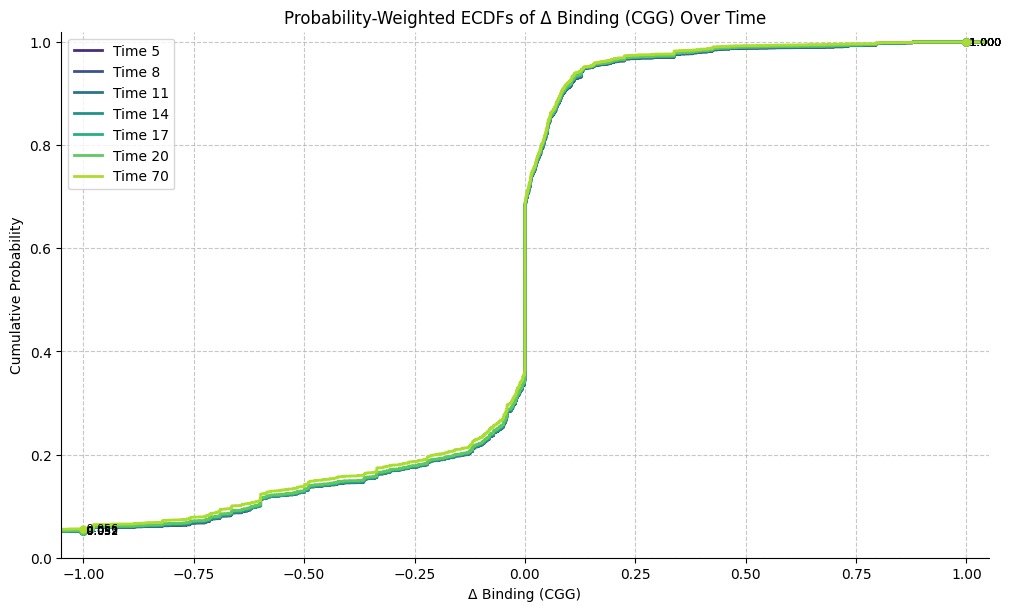

In [21]:
def plot_weighted_ecdf(ax, mut_probs_by_time, colors=None):
    """
    Plot probability-weighted ECDFs of delta_bind_CGG values for multiple timepoints.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    mut_probs_by_time : dict
        Dictionary mapping timepoint to DataFrames containing 'prob_tot' and 'delta_bind_CGG' columns.
    colors : list or None
        Colors for each timepoint ECDF line. If None, a default color palette will be used.
    """
    # Create a default color palette if not provided
    if colors is None:
        colors = sns.color_palette("viridis", len(mut_probs_by_time))
    
    # Plot ECDF for each timepoint
    for i, (timepoint, df) in enumerate(sorted(mut_probs_by_time.items())):
        # Filter out rows with NaN in delta_bind_CGG
        valid_data = df.dropna(subset=['delta_bind_CGG'])
        
        if len(valid_data) == 0:
            continue
        
        # Get weights and values
        weights = valid_data['prob_tot'].values
        values = valid_data['delta_bind_CGG'].values
        
        # Normalize weights to sum to 1
        weights = weights / weights.sum()
        
        # Sort values and compute cumulative probabilities
        sorted_indices = np.argsort(values)
        sorted_values = values[sorted_indices]
        sorted_weights = weights[sorted_indices]
        cumulative_prob = np.cumsum(sorted_weights)
        
        # Plot ECDF
        ax.step(
            sorted_values, 
            cumulative_prob, 
            where='post',
            color=colors[i], 
            linewidth=2,
            label=f"Time {timepoint}"
        )
        
        # Annotate points below -1 and above 1 if they exist
        below_min = np.sum(weights[values < -1])
        if below_min > 0:
            ax.plot([-1], [below_min], 'o', color=colors[i], markersize=5)
            ax.text(-1, below_min, f" {below_min:.3f}", va='center', fontsize=8)
        
        # Find the cumulative probability at value = 1
        above_max_idx = np.searchsorted(sorted_values, 1, side='right') - 1
        if above_max_idx >= 0:
            cum_prob_at_max = cumulative_prob[above_max_idx]
            ax.plot([1], [cum_prob_at_max], 'o', color=colors[i], markersize=5)
            
            # Only annotate if there are values above 1
            if cum_prob_at_max < 1:
                ax.text(1, cum_prob_at_max, f" {cum_prob_at_max:.3f}", va='center', fontsize=8)
    
    # Add grid, legend, and labels
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best')
    ax.set_xlabel('Δ Binding (CGG)')
    ax.set_ylabel('Cumulative Probability')
    
    # Set axis limits
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(0, 1.02)
    
    # Despine
    sns.despine(ax=ax)

# Create a figure with a single axes
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# Colors for the ECDFs
colors = sns.color_palette("viridis", len(mut_probs_by_time))

# Plot all timepoints on the same axes
plot_weighted_ecdf(ax, mut_probs_by_time, colors=colors)

# Add a title
ax.set_title("Probability-Weighted ECDFs of Δ Binding (CGG) Over Time")

# Show the plot
plt.show()